In [1]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

np.random.seed(42)


df = pd.read_csv('data/binance/BTCUSDT_1m_Futures.csv', index_col=0, parse_dates=True)
data = df[['Open', 'High', 'Low', 'Close', 'Volume']][-100000:]

data



,Open,High,Low,Close,Volume
Date,,,,,
2024-04-10 12:34:00,68792.8,68847.9,68792.8,68800.5,79.848
2024-04-10 12:35:00,68800.5,68824.9,68706.3,68745.4,198.843
2024-04-10 12:36:00,68745.4,68804.0,68700.0,68803.9,381.298
2024-04-10 12:37:00,68803.9,68808.4,68772.3,68780.1,97.852
2024-04-10 12:38:00,68780.0,68811.5,68762.6,68802.6,62.916
...,...,...,...,...,...
2024-06-18 23:09:00,64832.0,64892.1,64816.5,64866.3,55.603
2024-06-18 23:10:00,64866.3,64916.3,64847.6,64908.5,94.875
2024-06-18 23:11:00,64908.5,64946.1,64908.4,64932.0,70.477


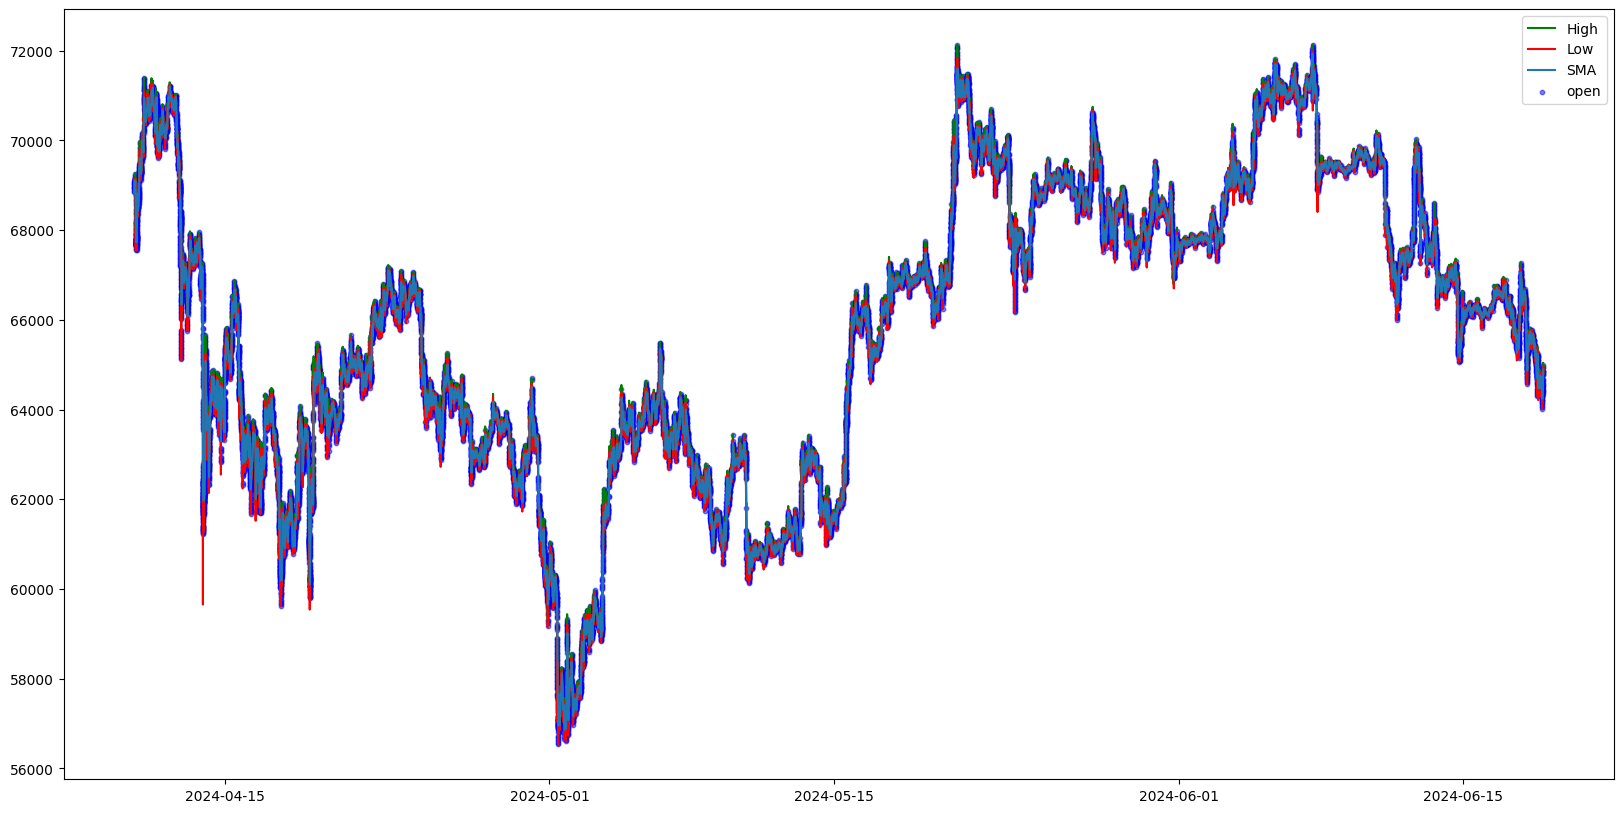

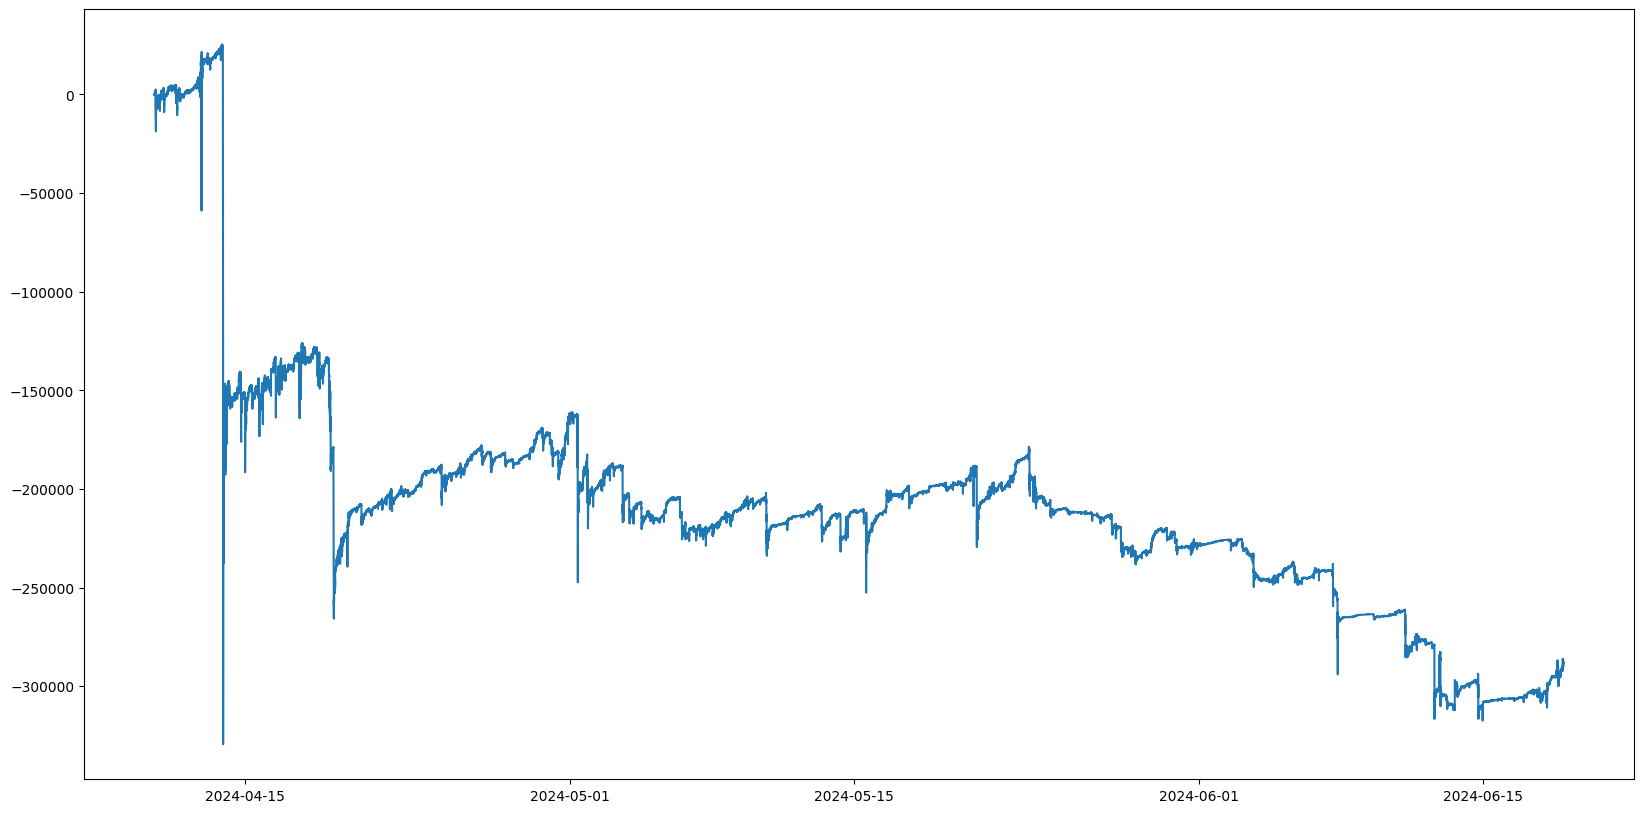

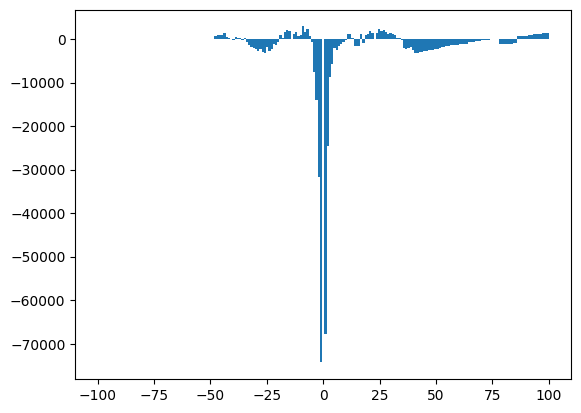

In [2]:

class Backtest:
    def __init__(self, data, num_grid=200, max_diff=1000):
        
        self.num_grid = num_grid
    
        self.data = data
        
        self.data['SMA'] = self.data['Close'].rolling(window=20).mean()
        
        self.max_diff = (self.data['Close'] - self.data['SMA']).abs().max().round(3)
        
        
        self.data = self.data.dropna()
        
        self.orders = {
                'id': np.linspace(-self.num_grid//2, self.num_grid//2, self.num_grid+1, dtype=int),
                'open_price': np.linspace(self.max_diff, -self.max_diff, self.num_grid+1),
                'close_price': np.zeros(self.num_grid+1),
                'amount': np.concatenate([-np.ones(self.num_grid//2), np.zeros(1), np.ones(self.num_grid//2)]),
                'opened_time': np.full(self.num_grid+1, self.data.index[0]),
                'opened_price': np.full(self.num_grid+1, -1),
            }
        
        self.orders = pd.DataFrame(self.orders).to_records(index=False)
        self.data = self.data.to_records()

        self.positions = []
    
    def run(self):

        for i, row in enumerate(self.data):
            
            
            for j, order in enumerate(self.orders):
                
                open_price = order['open_price'] + row['SMA']
                
                close_price = order['close_price'] + row['SMA']
                
                
                if order['opened_price'] == -1: # not opened
                    
                    if order['amount'] > 0: # long
                        if row['Low'] < open_price:
                            self.orders[j]['opened_price'] = open_price
                            self.orders[j]['opened_time'] = row['Date']
                    elif order['amount'] < 0: # short
                        if row['High'] > open_price:
                            self.orders[j]['opened_price'] = open_price
                            self.orders[j]['opened_time'] = row['Date']
                else: # opened
                    if order['amount'] > 0: # long
                        if row['High'] > close_price:
                            self.positions.append({
                                'id': order['id'],
                                'open_price': order['opened_price'],
                                'close_price': close_price,
                                'opened_time': order['opened_time'],
                                'closed_time': row['Date'],
                                'amount': order['amount'],
                                
                            })
                            self.orders[j]['opened_price'] = -1
                    elif order['amount'] < 0:
                        if row['Low'] < close_price:
                            self.positions.append({
                                'id': order['id'],
                                'open_price': order['opened_price'],
                                'close_price': close_price,
                                'opened_time': order['opened_time'],
                                'closed_time': row['Date'],
                                'amount': order['amount'],
                            })
                            self.orders[j]['opened_price'] = -1
        self.positions = pd.DataFrame(self.positions).to_records(index=False)
        
    def calc(self):
        
        usdt_balance = np.zeros([len(self.data), self.num_grid+1])
        crypto_balance = np.zeros([len(self.data), self.num_grid+1])
        
        for i, row in enumerate(self.data):
            
            for pos in self.positions[self.positions['opened_time'] == row['Date']]:
                
                positive_id = pos['id'] + self.num_grid//2

                usdt_balance[i, positive_id] = - pos['open_price'] * pos['amount']
                crypto_balance[i, positive_id] = pos['amount']
            

            for pos in self.positions[self.positions['closed_time'] == row['Date']]:
                positive_id = pos['id'] + self.num_grid//2

                usdt_balance[i, positive_id] = pos['close_price'] * pos['amount']
                crypto_balance[i, positive_id] = - pos['amount']
                
        self.usdt_returns = usdt_balance.sum(axis=0)
        self.crypto_returns = crypto_balance.sum(axis=0)
        
        self.total_returns = self.usdt_returns + self.crypto_returns * self.data['Close'][-1]
                        
        self.usdt_balance = usdt_balance.cumsum(axis=0)
        self.crypto_balance = crypto_balance.cumsum(axis=0)
        
        self.total_balance = self.usdt_balance + self.crypto_balance * self.data['Close'].reshape(-1, 1)

        return self.positions
    
    
    def plot(self, figsize=(20, 10)  ):
        
        
        plt.figure(figsize=figsize)
        plt.plot(self.data.Date, self.data['High'], label='High', color='green')
        plt.plot(self.data.Date, self.data['Low'], label='Low', color='red')
        plt.plot(self.data.Date, self.data['SMA'], label='SMA')
        plt.scatter(self.positions['opened_time'], self.positions['open_price'], label='open', color='blue', alpha=0.5, s=10)

        plt.legend()
        plt.show()
        
        plt.figure(figsize=figsize)
        plt.plot(self.data.Date, self.total_balance.sum(axis=1), label='total balance')
        plt.show()
        
        plt.hist(x=self.orders['id'] ,  weights=self.total_returns, bins=self.num_grid+1)
        
                    
                    
bt = Backtest(data)
bt.run()
bt.calc()
bt.plot()

In [ ]:
d = bt.positions

In [87]:
from numba import jit, njit, prange

class Backtest:
    def __init__(self, data, num_grid=200, max_diff=1000):
        
        self.num_grid = num_grid
    
        self.data = data
        
        self.data['SMA'] = self.data['Close'].rolling(window=20).mean().round(1)
        
        self.max_diff = (self.data['Close'] - self.data['SMA']).abs().max().round(-2)
        
        self.data = self.data.dropna()
        

        self.orders = {
                'id': np.linspace(-self.num_grid//2, self.num_grid//2, self.num_grid+1, dtype=int),
                'open_price': np.linspace(self.max_diff, -self.max_diff, self.num_grid+1),
                'close_price': np.zeros(self.num_grid+1),
                'amount': np.concatenate([-np.ones(self.num_grid//2), np.zeros(1), np.ones(self.num_grid//2)]),
            }
        
        self.orders = pd.DataFrame(self.orders)
        
        
        
    @staticmethod
    @njit(parallel=True, fastmath=True)
    def run_jit( data, orders):
        
        # positions = []
        
        opened_idx = np.full(len(orders), -1)
        opened_price = np.full(len(orders), -1)
        
        positions = np.zeros((len(data), len(orders), 2), dtype=np.float64)

        for i in prange(len(data)):
            
            open, high, low, close, volume, sma = data[i]
            
            for j, (id, open_price, close_price, amount) in enumerate(orders):
                
                open_price = open_price + sma
                close_price = close_price + sma
                
                if opened_price[j] < 0: # not opened
                    if amount > 0: # long
                        if low < open_price:
                            opened_price[j] = open_price
                            opened_idx[j] = i
                    elif amount < 0: # short
                        if high > open_price:
                            opened_price[j] = open_price
                            opened_idx[j] = i
                else: # opened
                    if amount > 0: # long
                        if high > close_price:
                            positions[opened_idx[j], j, 0] = opened_price[j]
                            positions[i, j, 0] = close_price
                            
                            positions[opened_idx[j], j, 1] = 1
                            positions[i, j, 1] = -1

                            opened_price[j] = -1
                            opened_idx[j] = -1

                    elif amount < 0: # short
                        if low < close_price:
                            
                            positions[opened_idx[j], j, 0] = opened_price[j]
                            positions[i, j, 0] = close_price
                            
                            positions[opened_idx[j], j, 1] = 1
                            positions[i, j, 1] = -1

                            opened_price[j] = -1
                            opened_idx[j] = -1
                            
        return positions

    def run(self):
        
        positions = self.run_jit(self.data.to_numpy(), self.orders.to_numpy())
        
        # self.positions = np.stack([np.abs(positions), np.sign(positions)])
        self.positions = positions



    
    # def calc_balance(self):


bt = Backtest(data)

bt.run()

In [59]:
t = bt.positions

In [88]:
%timeit bt = Backtest(data) 
%timeit bt.run()
# %timeit bt.calc_balance()

4.1 ms ± 32.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
59.9 ms ± 2.96 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
d = bt.positions

In [ ]:
from numba import jit
class Backtest:
    def __init__(self, data, num_grid=200, max_diff=1000):
        
        self.num_grid = num_grid
    
        self.data = data
        
        self.data['SMA'] = self.data['Close'].rolling(window=20).mean()
        
        self.max_diff = (self.data['Close'] - self.data['SMA']).abs().max().round(-2)
        
        
        self.data = self.data.dropna()
        
        self.orders = {
                'id': np.linspace(-self.num_grid//2, self.num_grid//2, self.num_grid+1, dtype=int),
                'open_price': np.linspace(-self.max_diff, self.max_diff, self.num_grid+1),
                'close_price': np.zeros(self.num_grid+1),
                'amount': np.concatenate([np.ones(self.num_grid//2), np.zeros(1), -np.ones(self.num_grid//2)]),
                'opened_time': np.full(self.num_grid+1, self.data.index[0]),
                'opened_price': np.full(self.num_grid+1, -1),
            }
        
        self.orders = pd.DataFrame(self.orders).to_records(index=False)
        self.data = self.data.to_records()
        
        print(self.orders)
        
        self.positions = []
        
    @staticmethod
    @jit(nopython=True) 
    def calc_diff(data, orders, positions):
        
        new_orders = orders.copy()
        for row in data:
            for order in orders:
                if order['opened_price'] == -1:
                    if row['Close'] > order['open_price']:
                        
                        new_orders['opened_price'] = row['Close']
                        new_orders['opened_time'] = row['Date']
                else:
                    if row['Close'] < order['open_price']:
                        new_orders['close_price'] = row['Close']
                        new_orders['opened_price'] = -1
                        new_orders['opened_time'] = row['Date']
                        
                        
        return orders, positions
        
    
    
    def run(self):

        for i, row in enumerate(self.data):
            
            
            for j, order in enumerate(self.orders):
                
                order['open_price'] = order['open_price'] + row['SMA']
                
                order['close_price'] = order['open_price'] + row['SMA']
                
                
                if order['opened_price'] == -1: # not opened
                    
                    if order['amount'] > 0: # long
                        if row['Low'] < order['open_price']:
                            self.orders[j]['opened_price'] = order['open_price']
                            self.orders[j]['opened_time'] = row['Date']
                    elif order['amount'] < 0: # short
                        if row['High'] > order['open_price']:
                            self.orders[j]['opened_price'] = order['open_price']
                            self.orders[j]['opened_time'] = row['Date']
                else: # opened
                    if order['amount'] > 0: # long
                        if row['High'] > order['close_price']:
                            self.positions.append({
                                'id': order['id'],
                                'open_price': order['opened_price'],
                                'close_price': order['close_price'],
                                'opened_time': order['opened_time'],
                                'closed_time': row['Date'],
                                'amount': order['amount'],
                                
                            })
                            self.orders[j]['opened_price'] = -1
                    elif order['amount'] < 0:
                        if row['Low'] < order['close_price']:
                            self.positions.append({
                                'id': order['id'],
                                'open_price': order['opened_price'],
                                'close_price': order['close_price'],
                                'opened_time': order['opened_time'],
                                'closed_time': row['Date'],
                                'amount': order['amount'],
                            })
                            self.orders[j]['opened_price'] = -1
    
        self.positions = pd.DataFrame(self.positions).to_records(index=False)
        
    @staticmethod
    @jit(nopython=True)
    def run_jit(data, orders):
        positions = []
        
        for i, row in enumerate(data):
            
            
            for j, order in enumerate(orders):
                
                order['open_price'] = order['open_price'] + row['SMA']
                
                order['close_price'] = order['open_price'] + row['SMA']
                
                
                if order['opened_price'] == -1: # not opened
                    
                    if order['amount'] > 0: # long
                        if row['Low'] < order['open_price']:
                            orders[j]['opened_price'] = order['open_price']
                            orders[j]['opened_time'] = row['Date']
                    elif order['amount'] < 0: # short
                        if row['High'] > order['open_price']:
                            orders[j]['opened_price'] = order['open_price']
                            orders[j]['opened_time'] = row['Date']
                else: # opened
                    if order['amount'] > 0: # long
                        if row['High'] > order['close_price']:
                            positions.append({
                                'id': order['id'],
                                'open_price': order['opened_price'],
                                'close_price': order['close_price'],
                                'opened_time': order['opened_time'],
                                'closed_time': row['Date'],
                                'amount': order['amount'],
                                
                            })
                            orders[j]['opened_price'] = -1
                    elif order['amount'] < 0:
                        if row['Low'] < order['close_price']:
                            positions.append({
                                'id': order['id'],
                                'open_price': order['opened_price'],
                                'close_price': order['close_price'],
                                'opened_time': order['opened_time'],
                                'closed_time': row['Date'],
                                'amount': order['amount'],
                            })
                            orders[j]['opened_price'] = -1
        return positions
            
    def run_numba(self):

        self.positions = self.run_jit(self.data, self.orders)
    
        self.positions = pd.DataFrame(self.positions).to_records(index=False)
        
    def calc(self):
        
        usdt = 1000
        crypto = 0
        
        usdt_balance = np.zeros([self.num_grid, len(self.data)])
        crypto_balance = np.zeros([self.num_grid, len(self.data)])
        
        for i, row in enumerate(self.data):
            
            for j, pos in enumerate(self.positions):
                if pos['opened_time'] == row['Date']:
                    usdt -= pos['open_price'] * pos['amount']
                    crypto += pos['amount']
            
            if self.positions['opened_time'] == row['Date']:
                usdt -= self.positions['open_price'] * self.positions['amount']
                crypto += self.positions['amount']
                
            
        return self.positions

                    
                    
bt = Backtest(data)
bt.run()

In [ ]:
%% timeit use_numba_dict(numba_dict)

In [ ]:
from numba import jit, njit, prange

class Backtest:
    def __init__(self, data, num_grid=200, max_diff=1000):
        
        self.num_grid = num_grid
    
        self.data = data
        
        self.data['SMA'] = self.data['Close'].rolling(window=20).mean().round(1)
        
        self.max_diff = (self.data['Close'] - self.data['SMA']).abs().max().round(-2)
        
        self.data = self.data.dropna()
        

        self.orders = {
                'id': np.linspace(-self.num_grid//2, self.num_grid//2, self.num_grid+1, dtype=int),
                'open_price': np.linspace(self.max_diff, -self.max_diff, self.num_grid+1),
                'close_price': np.zeros(self.num_grid+1),
                'amount': np.concatenate([-np.ones(self.num_grid//2), np.zeros(1), np.ones(self.num_grid//2)]),
            }
        
        self.orders = pd.DataFrame(self.orders)
        
        
        
    @staticmethod
    @njit(parallel=True, fastmath=True)
    def run_jit( data, orders):
        
        # positions = []
        
        opened_idx = np.full(len(orders), -1)
        opened_price = np.full(len(orders), -1)
        
        positions = np.zeros((len(data), len(orders), 2), dtype=np.float64)

        for i in prange(len(data)):
            
            open, high, low, close, volume, sma = data[i]
            
            for j, (id, open_price, close_price, amount) in enumerate(orders):
                
                open_price = open_price + sma
                close_price = close_price + sma
                
                if opened_price[j] < 0: # not opened
                    if amount > 0: # long
                        if low < open_price:
                            opened_price[j] = open_price
                            opened_idx[j] = i
                    elif amount < 0: # short
                        if high > open_price:
                            opened_price[j] = open_price
                            opened_idx[j] = i
                else: # opened
                    if amount > 0: # long
                        if high > close_price:
                            positions[opened_idx[j], j, 0] = opened_price[j]
                            positions[i, j, 0] = close_price
                            
                            positions[opened_idx[j], j, 1] = 1
                            positions[i, j, 1] = -1

                            opened_price[j] = -1
                            opened_idx[j] = -1

                    elif amount < 0: # short
                        if low < close_price:
                            
                            positions[opened_idx[j], j, 0] = opened_price[j]
                            positions[i, j, 0] = close_price
                            
                            positions[opened_idx[j], j, 1] = 1
                            positions[i, j, 1] = -1

                            opened_price[j] = -1
                            opened_idx[j] = -1
                            
        return positions

    def run(self):
        
        positions = self.run_jit(self.data.to_numpy(), self.orders.to_numpy())
        
        # self.positions = np.stack([np.abs(positions), np.sign(positions)])
        self.positions = positions



    
    # def calc_balance(self):


bt = Backtest(data)

bt.run()